### 1. 프로젝트 개요 및 환경 설정

본 프로젝트는 NSMC(Naver Sentiment Movie Corpus) 데이터셋을 활용하여 한국어 텍스트의 감성을 분류하는 다양한 모델링 방법론을 비교 분석합니다. 통계 기반 머신러닝(TF-IDF, Word2Vec, Decision Tree)부터 딥러닝(CNN, LSTM)까지 단계적으로 적용하며, 특히 전처리 수준(Raw, Morpheme, Jamo)이 성능에 미치는 영향을 규명합니다.


---

#### [필독] Google Colab 실행 가이드
본 코드는 별도의 구글 드라이브 마운트 없이, **Colab 임시 저장소**를 사용하여 실행되도록 구성되어 있습니다. 코드를 실행하기 전, 아래 절차에 따라 데이터 파일을 배치해야 합니다.

1.  **준비 파일:** `ratings_train.txt`, `ratings_test.txt`, `decisions_to_make.csv` (총 3개)
2.  **업로드 방법:** Colab 화면 왼쪽 **폴더 아이콘(파일)** 클릭 $\rightarrow$ 현재 경로(`/content`)에 파일 3개를 **드래그 앤 드롭**하여 업로드
3.  **실행:** 파일 업로드가 완료되면 상단 메뉴의 **[런타임]** $\rightarrow$ **[모두 실행]** 클릭

*(런타임이 초기화되면 업로드한 파일이 삭제되므로 재접속 시 다시 업로드해야 합니다.)*

---

**참여자 정보**
*   정보시스템학과 2024062042 김규민
*   정보시스템학과 2023092606 송정빈

**실험 환경**
*   플랫폼: Google Colab (GPU T4)
*   Python: 3.12.12 호환
*   데이터: 위 가이드에 따라 업로드된 3개 파일 (`/content` 경로)

In [ ]:
# 1. Mecab 설치 (C++ 기반의 고속 형태소 분석기 python-mecab-ko)
!pip install python-mecab-ko

# 2. 공통 라이브러리 및 자소 분리 패키지 설치
!pip install jamo gensim torch scikit-learn pandas numpy matplotlib seaborn tqdm wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 579.6/579.6 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 91.7 MB/s eta 0:00:00


### 2. 라이브러리 임포트 및 시드 고정

실험에 필요한 라이브러리를 import하고, 재현성을 위해 Seed를 고정합니다.


In [ ]:
import os
import re
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from mecab import MeCab
from jamo import h2j, j2hcj
from gensim.models import Word2Vec
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# 시드 고정 함수
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


### EDA 및 전처리

In [ ]:
def generate_clean_train_hybrid(input_path, output_path, decision_csv='decisions_to_make.csv'):
    print(f"--- [EDA Cleaning] Processing: {input_path} ---")
    if not os.path.exists(input_path):
        print(f"File not found: {input_path}")
        return

    # 1. 데이터 로드 및 중복 그룹화
    df = pd.read_csv(input_path, sep='\t').dropna()
    initial_len = len(df)

    duplicates = df[df.duplicated(subset=['document'], keep=False)]
    non_duplicates = df[~df['document'].isin(duplicates['document'])].copy()

    if duplicates.empty:
        df.to_csv(output_path, sep='\t', index=False)
        print("중복 없음. 원본 그대로 저장.")
        return

    # 라벨 평균 및 빈도 계산
    stats = duplicates.groupby('document')['label'].agg(['mean', 'count']).reset_index()

    # 2. 임계값 기반 자동 분류
    HIGH_THR = 0.9
    LOW_THR = 0.1

    auto_pos = stats[stats['mean'] >= HIGH_THR]
    auto_neg = stats[stats['mean'] <= LOW_THR]

    # 3. 수동 검토 대상 식별
    ambiguous_df = stats[(stats['mean'] < HIGH_THR) & (stats['mean'] > LOW_THR)].copy()

    manual_decisions = {}

    if os.path.exists(decision_csv):
        print(f"Loading existing manual decisions from: {decision_csv}")
        reviewed_df = pd.read_csv(decision_csv)

        if 'final_label' in reviewed_df.columns:
            valid_decisions = reviewed_df.dropna(subset=['final_label'])
            manual_decisions = dict(zip(valid_decisions['document'], valid_decisions['final_label']))
            print(f" -> {len(manual_decisions)} manual entries found.")

    # 4. 최종 데이터셋 조립
    final_rows = []

    # (1) 중복 아니었던 데이터
    final_rows.append(non_duplicates)

    # (2) 자동 분류 데이터
    pos_df = pd.DataFrame({'document': auto_pos['document'], 'label': 1})
    neg_df = pd.DataFrame({'document': auto_neg['document'], 'label': 0})
    final_rows.append(pos_df)
    final_rows.append(neg_df)

    # (3) 수동 결정 데이터 처리 (0, 1, drop 로직)
    manual_data_list = []
    dropped_count = 0

    if manual_decisions:
        for doc, lbl in manual_decisions.items():
            # 문자열로 변환 후 공백제거 및 소문자 처리 (1.0 -> 1 처리 포함)
            val = str(lbl).strip().lower().replace('.0', '')

            if val == '1':
                manual_data_list.append({'document': doc, 'label': 1})
            elif val == '0':
                manual_data_list.append({'document': doc, 'label': 0})
            elif val == 'drop':
                dropped_count += 1
                # 리스트에 추가 안 함 -> 자연스럽게 삭제됨
            else:
                # 0, 1, drop 이외의 값은 무시 (나중에 다시 결정하도록)
                pass

        if manual_data_list:
            manual_df = pd.DataFrame(manual_data_list)
            final_rows.append(manual_df)

    # 병합
    final_df = pd.concat(final_rows, ignore_index=True)

    # 5. 저장
    final_df = final_df[['document', 'label']]
    final_df.to_csv(output_path, sep='\t', index=False)

    print(f"\n[Result Summary]")
    print(f" Original Rows: {initial_len}")
    print(f" Final Rows:    {len(final_df)}")
    print(f"  - Auto Resolved: {len(pos_df) + len(neg_df)}")
    print(f"  - Manually Added:{len(manual_data_list)}")
    print(f"  - Manually Dropped: {dropped_count}")
    print(f" Saved Output:  {output_path}")

# 실행
generate_clean_train_hybrid('ratings_train.txt', 'ratings_train_eda.txt')

--- [EDA Cleaning] Processing: ratings_train.txt ---
Loading existing manual decisions from: decisions_to_make.csv
 -> 143 manual entries found.

[Result Summary]
 Original Rows: 149995
 Final Rows:    146123
  - Auto Resolved: 993
  - Manually Added:84
  - Manually Dropped: 59
 Saved Output:  ratings_train_eda.txt


In [ ]:
import matplotlib.font_manager as fm

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

sys_font = fm.findSystemFonts()
nanum_fonts = [f for f in sys_font if 'NanumBarunGothic.ttf' in f]

if nanum_fonts:
    font_path = nanum_fonts[0]
    print(f"폰트 파일 존재 -> {font_path}")
else:
    font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
    print(f"경로 강제 지정 (파일 존재 여부 확인 필요) -> {font_path}")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,161 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and dire

--- [EDA] Starting Analysis for: ratings_train.txt ---
Total Data Loaded: 149995

[1] 라벨 분포 확인


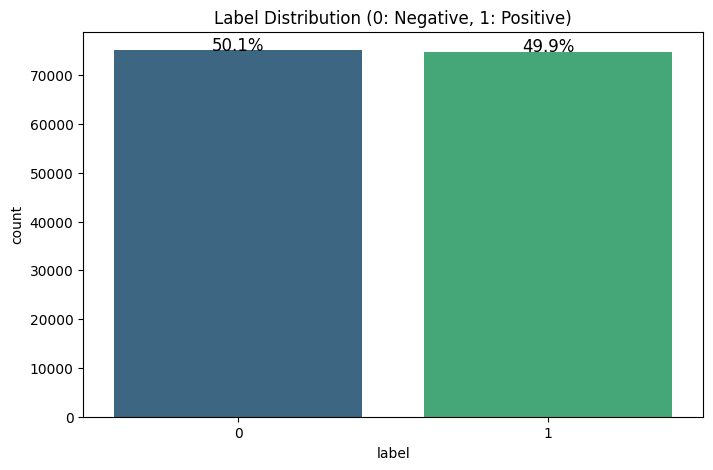


[2] 리뷰 길이 분석


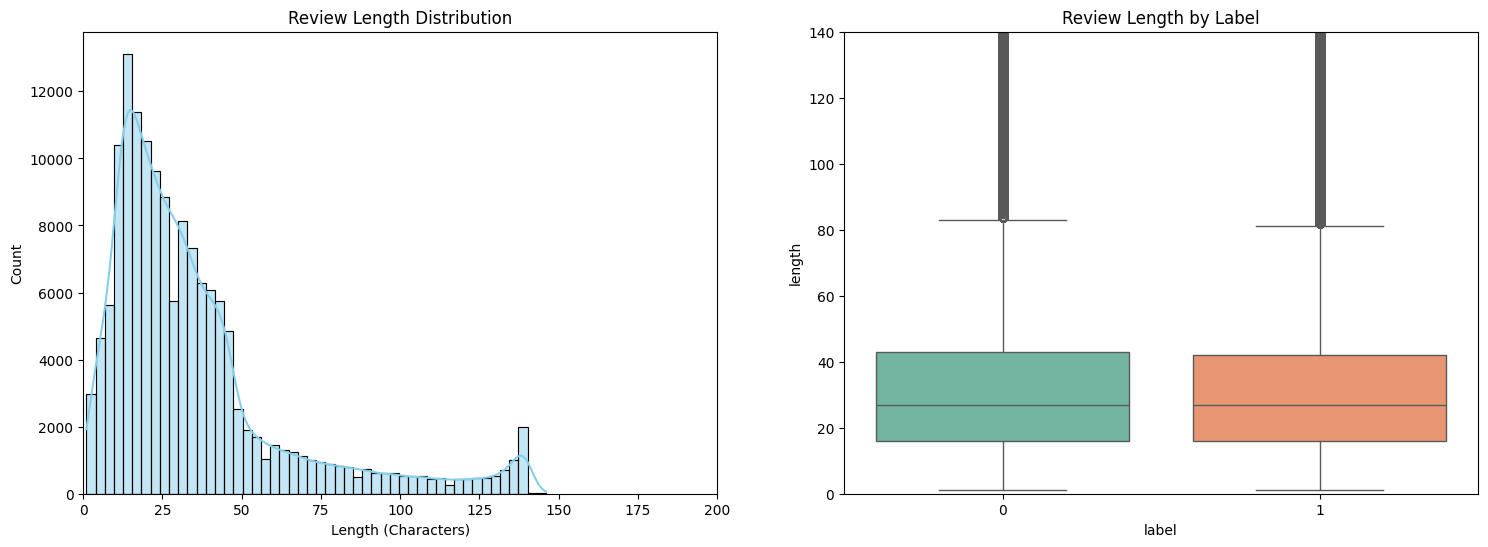

         count       mean        std  min   25%   50%   75%    max
label                                                             
0      75170.0  35.806319  30.343703  1.0  16.0  27.0  43.0  146.0
1      74825.0  34.599960  28.680707  1.0  16.0  27.0  42.0  146.0

[3] WordCloud 생성 (불용어 식별용)


Tokenizing Negative Reviews: 100%|██████████| 75170/75170 [00:15<00:00, 4775.37it/s]


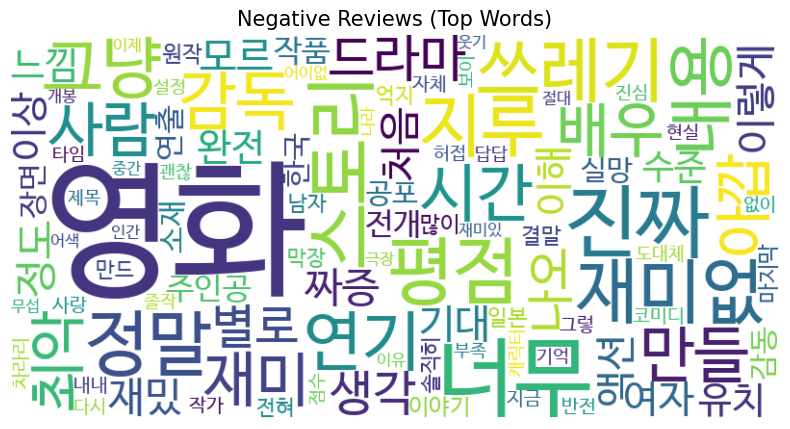

[Negative Reviews] Top 20 Words: ['영화', '너무', '진짜', '평점', '스토리', '재미없', '쓰레기', '정말', '지루', '그냥', '내용', '연기', '감독', '시간', '만들', '사람', '재미', '배우', '아깝', '최악']



Tokenizing Positive Reviews: 100%|██████████| 74825/74825 [00:15<00:00, 4697.62it/s]


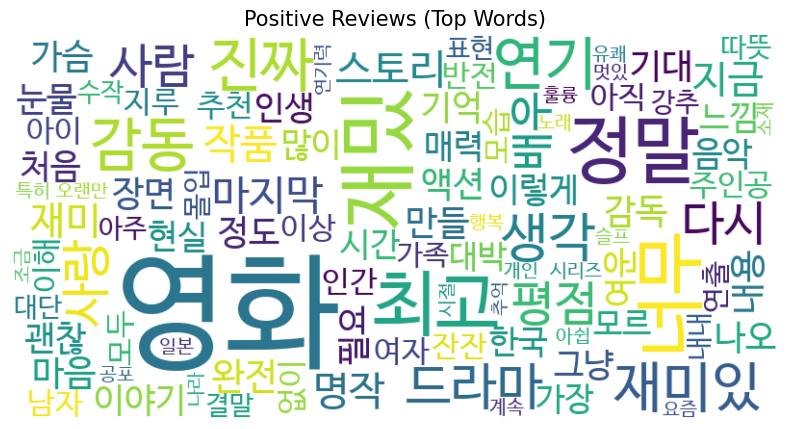

[Positive Reviews] Top 20 Words: ['영화', '재밌', '정말', '최고', '너무', '진짜', '연기', '감동', '재미있', '생각', '드라마', '사랑', '평점', '사람', '다시', '배우', '스토리', '마지막', '작품', '명작']



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from mecab import MeCab
from tqdm import tqdm

def run_comprehensive_eda(input_path, custom_font_path):
    print(f"--- [EDA] Starting Analysis for: {input_path} ---")

    if not os.path.exists(input_path):
        print(f"Error: File not found: {input_path}")
        return

    # 데이터 로드
    df = pd.read_csv(input_path, sep='\t').dropna()
    print(f"Total Data Loaded: {len(df)}")

    # [Part 1] 라벨(Label) 분포 분석 (Warning Fix)
    print("\n[1] 라벨 분포 확인")
    f, ax = plt.subplots(1, 1, figsize=(8, 5))
    sns.countplot(x='label', data=df, hue='label', legend=False, palette='viridis', ax=ax)

    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 3,
                f'{100 * height/total:.1f}%', ha="center", fontsize=12)

    plt.title('Label Distribution (0: Negative, 1: Positive)')
    plt.show()

    # [Part 2] 리뷰 길이 분석 (Warning Fix)
    print("\n[2] 리뷰 길이 분석")
    df['length'] = df['document'].astype(str).apply(len)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # 히스토그램
    sns.histplot(df['length'], bins=50, kde=True, color='skyblue', ax=ax1)
    ax1.set_title('Review Length Distribution')
    ax1.set_xlabel('Length (Characters)')
    ax1.set_xlim(0, 200)

    # 박스플롯
    sns.boxplot(x='label', y='length', data=df, hue='label', legend=False, palette='Set2', ax=ax2)
    ax2.set_title('Review Length by Label')
    ax2.set_ylim(0, 140)

    plt.show()
    print(df.groupby('label')['length'].describe())

    # [Part 3] WordCloud 시각화
    print("\n[3] WordCloud 생성 (불용어 식별용)")
    mecab_wc = MeCab()
    TARGET_TAGS = ['NNG', 'NNP', 'VA', 'VV', 'XR', 'MAG']

    def generate_and_plot(label_code, title):
        texts = df[df['label'] == label_code]['document'].astype(str).tolist()
        all_tokens = []

        for text in tqdm(texts, desc=f"Tokenizing {title}"):
            try:
                pos = mecab_wc.pos(text)
                words = [word for word, tag in pos if tag in TARGET_TAGS and len(word) > 1]
                all_tokens.extend(words)
            except:
                continue

        counts = Counter(all_tokens)

        try:
            # Step 1에서 찾은 font_path를 사용
            wc = WordCloud(
                font_path=custom_font_path,
                background_color='white',
                width=800, height=400,
                max_words=100
            ).generate_from_frequencies(counts)

            plt.figure(figsize=(10, 5))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis('off')
            plt.title(f"{title} (Top Words)", fontsize=15)
            plt.show()

            print(f"[{title}] Top 20 Words: {[w for w, c in counts.most_common(20)]}\n")

        except Exception as e:
            print(f"WordCloud Error (폰트 경로 확인 필요): {e}")

    generate_and_plot(0, "Negative Reviews")
    generate_and_plot(1, "Positive Reviews")

# Step 1에서 찾은 font_path 전달
run_comprehensive_eda('ratings_train.txt', font_path)

### 3. 데이터 로드 및 전처리 파이프라인

전처리 파이프라인 상세 계획에 따라 3가지 전략을 구현하였습니다.
*   **Pipeline A (Raw):** 띄어쓰기 기준 분절.
*   **Pipeline B (Morpheme):** Mecab 형태소 분석 + 불용어 제거.
*   **Pipeline C (Jamo):** 자소 단위 분해.

처리된 데이터는 `pickle`로 캐싱하여 재실행 시 시간을 단축하고자 합니다.


In [ ]:
# 불용어 리스트
STOPWORDS = set(['은', '는', '이', '가', '을', '를', '의', '에', '와', '과', '도', '으로', '만', '하다'])

# 1. 도메인 불용어 및 태그 정의 (EDA 분석 결과를 반영하였습니다)
DOMAIN_STOPWORDS = {'영화', '배우', '연기', '감독', '스토리', '내용', '작품', '관람', '그냥', '진짜', '정말'}
# 제거할 품사 태그 (조사, 어미, 접미사 등)
DROP_TAGS = ('J', 'E', 'XS', 'SV', 'VX')

# 2. 감정 기호 보존 정제 함수
def clean_text_eda(text):
    if pd.isna(text): return ""
    # 한글, 영문, 공백 + 감정기호(!?.) + 자음 보존
    text = re.sub(r'[^가-힣a-zA-Z0-9\s!?.ㅋㅎ]', '', str(text))
    return text.strip()

# 3. 기존 clean_text (비교군)
def clean_text_baseline(text):
    if pd.isna(text): return ""
    text = re.sub(r'[^ㄱ-ㅎ가-힣0-9a-zA-Z ]', '', str(text))
    return text.strip()

class Preprocessor:
    def __init__(self):
        self.mecab = MeCab()

    def process(self, text, method='raw'):
        if method == 'eda':
            text = clean_text_eda(text) # 감정기호 보존
            if not text: return []
            try:
                morphs = self.mecab.pos(text)
            except:
                return []
            tokens = []
            for word, tag in morphs:
                # 불용어 품사 제거
                if tag.startswith(DROP_TAGS): continue
                # 도메인 불용어 제거
                if word in DOMAIN_STOPWORDS: continue
                tokens.append(word)
            return tokens

        text = clean_text_baseline(text)
        if not text: return []

        if method == 'raw':
            return text.split()

        elif method == 'morpheme':
            morphs = self.mecab.morphs(text)
            return [m for m in morphs if m not in STOPWORDS and len(m) > 1]

        elif method == 'jamo':
            jamo_str = j2hcj(h2j(text))
            return list(jamo_str)

        return []

def load_and_preprocess(file_path, method, cache_name):
    # 캐시 확인
    if os.path.exists(cache_name):
        print(f"Loading cached data: {cache_name}")
        with open(cache_name, 'rb') as f:
            return pickle.load(f)

    # EDA 모드이고 학습 데이터인 경우, 정제된 파일로 경로를 변경
    target_file = file_path
    if method == 'eda' and 'ratings_train.txt' in file_path:
        target_file = 'ratings_train_eda.txt'
        print(f"  [EDA Mode] Creating High-Quality Train Data -> Switching to: {target_file}")

    print(f"Processing data ({method}): {target_file}")
    df = pd.read_csv(target_file, sep='\t').dropna()

    documents = df['document'].tolist()
    labels = df['label'].tolist()

    preprocessor = Preprocessor()
    tokens_list = []
    valid_labels = []

    for doc, label in tqdm(zip(documents, labels), total=len(documents)):
        tokens = preprocessor.process(doc, method)
        if tokens:
            tokens_list.append(tokens)
            valid_labels.append(label)

    data = {'tokens': tokens_list, 'labels': valid_labels}
    with open(cache_name, 'wb') as f:
        pickle.dump(data, f)
    return data

# 데이터셋 로드 (학습/테스트)
# 1. Raw Data (Pipeline A)
train_raw = load_and_preprocess('ratings_train.txt', 'raw', 'train_raw.pkl')
test_raw = load_and_preprocess('ratings_test.txt', 'raw', 'test_raw.pkl')

# 2. Morpheme Data (Pipeline B)
train_morphs = load_and_preprocess('ratings_train.txt', 'morpheme', 'train_morphs.pkl')
test_morphs = load_and_preprocess('ratings_test.txt', 'morpheme', 'test_morphs.pkl')

# 3. Jamo Data (Pipeline C) - 딥러닝 전용
train_jamo = load_and_preprocess('ratings_train.txt', 'jamo', 'train_jamo.pkl')
test_jamo = load_and_preprocess('ratings_test.txt', 'jamo', 'test_jamo.pkl')

# 4. EDA 분석 결과 기반으로 새롭게 전처리
train_eda = load_and_preprocess('ratings_train.txt', 'eda', 'train_eda.pkl')
test_eda = load_and_preprocess('ratings_test.txt', 'eda', 'test_eda.pkl')

Loading cached data: train_raw.pkl
Loading cached data: test_raw.pkl
Loading cached data: train_morphs.pkl
Loading cached data: test_morphs.pkl
Loading cached data: train_jamo.pkl
Loading cached data: test_jamo.pkl
Loading cached data: train_eda.pkl
Loading cached data: test_eda.pkl


### 4. 통계 기반 머신러닝 (Baseline)

사전에 설정했던 기본적인 머신러닝 기반 모델들을 통해 베이스라인 성능을 측정합니다.
*   **3.1 TF-IDF:** 단어 빈도 가중치 활용 + 로지스틱 회귀.
*   **3.2 Word2Vec:** 단어 임베딩 평균(Mean Pooling) + 로지스틱 회귀.
*   **3.3 Decision Tree:** TF-IDF 특성 + 결정 트리 분류기.


In [ ]:
def save_prediction(model_name, preds):
    with open(f'prediction_{model_name}.txt', 'w') as f:
        for p in preds:
            f.write(f"{int(p)}\n")
    print(f"Saved: prediction_{model_name}.txt")

# 공통 데이터 분할 함수
def split_train_valid(data_dict):
    tokens = data_dict['tokens']
    labels = data_dict['labels']
    # stratify를 사용하여 라벨 비율(긍정, 부정)을 유지하며 8:2 분할
    t_tokens, v_tokens, t_labels, v_labels = train_test_split(
        tokens, labels, test_size=0.2, random_state=42, stratify=labels
    )
    return (t_tokens, t_labels), (v_tokens, v_labels)

# 3.1 TF-IDF 모델링
def exp_tfidf(train_data, test_data, exp_name):
    print(f"\n=== Running {exp_name} (TF-IDF) ===")
    (t_tokens, t_labels), (v_tokens, v_labels) = split_train_valid(train_data)

    # 데이터 준비
    X_train = [" ".join(t) for t in t_tokens]
    X_valid = [" ".join(t) for t in v_tokens]
    X_test = [" ".join(t) for t in test_data['tokens']]

    vectorizer = TfidfVectorizer(min_df=5, max_features=10000)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_valid_vec = vectorizer.transform(X_valid) # 검증용
    X_test_vec = vectorizer.transform(X_test)   # 최종 테스트용

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_vec, t_labels)

    # 검증 성능 확인
    val_acc = accuracy_score(v_labels, model.predict(X_valid_vec))
    print(f"Validation Accuracy: {val_acc:.4f}")

    # 최종 테스트 예측
    preds = model.predict(X_test_vec)
    acc = accuracy_score(test_data['labels'], preds)
    print(f"Test Accuracy: {acc:.4f}")
    save_prediction(exp_name, preds)

# 3.2 Word2Vec 모델링
def exp_word2vec(train_data, test_data, exp_name):
    print(f"\n=== Running {exp_name} (Word2Vec) ===")
    (t_tokens, t_labels), (v_tokens, v_labels) = split_train_valid(train_data)

    # 전체 corpus로 W2V 학습 (Data Leakage 방지를 위해 t_tokens만 사용 권장되나, 임베딩 품질 위해 전체 사용하기도 함. 여기선 t_tokens만 사용)
    w2v_model = Word2Vec(sentences=t_tokens, vector_size=100, window=5, min_count=5, workers=4)

    def get_doc_vector(tokens, model):
        vecs = [model.wv[t] for t in tokens if t in model.wv]
        if len(vecs) > 0: return np.mean(vecs, axis=0)
        return np.zeros(model.vector_size)

    X_train = np.array([get_doc_vector(t, w2v_model) for t in t_tokens])
    X_valid = np.array([get_doc_vector(t, w2v_model) for t in v_tokens])
    X_test = np.array([get_doc_vector(t, w2v_model) for t in test_data['tokens']])

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, t_labels)

    val_acc = accuracy_score(v_labels, model.predict(X_valid))
    print(f"Validation Accuracy: {val_acc:.4f}")

    preds = model.predict(X_test)
    acc = accuracy_score(test_data['labels'], preds)
    print(f"Test Accuracy: {acc:.4f}")
    save_prediction(exp_name, preds)

# 3.3 Decision Tree 모델링
def exp_decision_tree(train_data, test_data, exp_name):
    print(f"\n=== Running {exp_name} (Decision Tree) ===")
    (t_tokens, t_labels), (v_tokens, v_labels) = split_train_valid(train_data)

    X_train = [" ".join(t) for t in t_tokens]
    X_valid = [" ".join(t) for t in v_tokens]
    X_test = [" ".join(t) for t in test_data['tokens']]

    vectorizer = TfidfVectorizer(min_df=5, max_features=5000)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_valid_vec = vectorizer.transform(X_valid)
    X_test_vec = vectorizer.transform(X_test)

    model = DecisionTreeClassifier(max_depth=20, random_state=42)
    model.fit(X_train_vec, t_labels)

    val_acc = accuracy_score(v_labels, model.predict(X_valid_vec))
    print(f"Validation Accuracy: {val_acc:.4f}")

    preds = model.predict(X_test_vec)
    acc = accuracy_score(test_data['labels'], preds)
    print(f"Test Accuracy: {acc:.4f}")
    save_prediction(exp_name, preds)

# 실험 실행
exp_tfidf(train_raw, test_raw, "TFIDF_Raw")         # Exp 1-1
exp_tfidf(train_morphs, test_morphs, "TFIDF_Pre")   # Exp 1-2
exp_tfidf(train_eda, test_eda, "TFIDF_EDA")         # Exp 1-3
exp_word2vec(train_raw, test_raw, "W2V_Raw")        # Exp 2-1
exp_word2vec(train_morphs, test_morphs, "W2V_Pre")  # Exp 2-2
exp_word2vec(train_eda, test_eda, "W2V_EDA")        # Exp 2-3
exp_decision_tree(train_raw, test_raw, "DT_Raw")    # Exp 3-1
exp_decision_tree(train_morphs, test_morphs, "DT_Pre") # Exp 3-2
exp_decision_tree(train_eda, test_eda, "DT_EDA")    # Exp 3-3


=== Running TFIDF_Raw (TF-IDF) ===
Validation Accuracy: 0.7807
Test Accuracy: 0.7790
Saved: prediction_TFIDF_Raw.txt

=== Running TFIDF_Pre (TF-IDF) ===
Validation Accuracy: 0.8180
Test Accuracy: 0.8179
Saved: prediction_TFIDF_Pre.txt

=== Running TFIDF_EDA (TF-IDF) ===
Validation Accuracy: 0.8135
Test Accuracy: 0.8055
Saved: prediction_TFIDF_EDA.txt

=== Running W2V_Raw (Word2Vec) ===
Validation Accuracy: 0.7213
Test Accuracy: 0.7174
Saved: prediction_W2V_Raw.txt

=== Running W2V_Pre (Word2Vec) ===
Validation Accuracy: 0.7825
Test Accuracy: 0.7817
Saved: prediction_W2V_Pre.txt

=== Running W2V_EDA (Word2Vec) ===
Validation Accuracy: 0.8077
Test Accuracy: 0.8053
Saved: prediction_W2V_EDA.txt

=== Running DT_Raw (Decision Tree) ===
Validation Accuracy: 0.5658
Test Accuracy: 0.5584
Saved: prediction_DT_Raw.txt

=== Running DT_Pre (Decision Tree) ===
Validation Accuracy: 0.6575
Test Accuracy: 0.6591
Saved: prediction_DT_Pre.txt

=== Running DT_EDA (Decision Tree) ===
Validation Accuracy:

### 5. 딥러닝 모델 준비 (Dataset & Vocabulary)

딥러닝 모델 학습을 위한 PyTorch Dataset 클래스와 단어장(Vocabulary) 구축 함수를 정의합니다.
*   **Special Tokens:** `<PAD>`: 0, `<UNK>`: 1
*   **Padding:** 배치 내 가변 길이를 처리하기 위해 패딩 적용.

In [ ]:
class Vocab:
    def __init__(self, tokens_list, min_freq=2):
        self.token2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2token = {0: '<PAD>', 1: '<UNK>'}
        self.build_vocab(tokens_list, min_freq)

    def build_vocab(self, tokens_list, min_freq):
        freqs = {}
        for tokens in tokens_list:
            for token in tokens:
                freqs[token] = freqs.get(token, 0) + 1

        idx = 2
        for token, count in freqs.items():
            if count >= min_freq:
                self.token2idx[token] = idx
                self.idx2token[idx] = token
                idx += 1
        print(f"Vocab size: {len(self.token2idx)}")

    def encode(self, tokens):
        return [self.token2idx.get(t, 1) for t in tokens]

class NSMCDataset(Dataset):
    def __init__(self, data_dict, vocab, max_len=140):
        self.data = data_dict['tokens']
        self.labels = data_dict['labels']
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens = self.data[idx]
        label = self.labels[idx]
        indices = self.vocab.encode(tokens)
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.float)

def collate_fn(batch):

    sequences, labels = zip(*batch)

    lengths = [len(s) for s in sequences]
    # Pad sequences
    padded_seqs = torch.zeros(len(sequences), max(lengths), dtype=torch.long)
    for i, seq in enumerate(sequences):
        end = lengths[i]
        padded_seqs[i, :end] = torch.tensor(seq)[:end]

    return padded_seqs, torch.tensor(labels), lengths

### 6. 딥러닝 모델 아키텍처

두 가지 핵심 아키텍처를 구현합니다.
1.  **TextCNN (1D-CNN):** `Conv1d` -> `MaxPool` 구조. 형태소, 음절, 자소 단위 모델에서 공유합니다.
2.  **TextLSTM:** `LSTM`을 사용하여 문맥을 학습합니다. `pack_padded_sequence`를 사용해 효율성을 높입니다.

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, out_channels=n_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, lengths=None):
        # text: [batch size, sent len]
        embedded = self.embedding(text) # [batch size, sent len, emb dim]
        embedded = embedded.permute(0, 2, 1) # [batch size, emb dim, sent len]

        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        # conved[n]: [batch size, n_filters, sent len - filter_sizes[n] + 1]

        pooled = [torch.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        # pooled[n]: [batch size, n_filters]

        cat = self.dropout(torch.cat(pooled, dim=1))
        return self.fc(cat)

class TextLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=bidirectional, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, lengths):
        embedded = self.dropout(self.embedding(text))

        packed_embedded = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)

        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        return self.fc(hidden)

### 7. 학습 및 추론 루프

딥러닝 모델을 학습하고, 테스트 데이터에 대해 추론을 수행하여 결과를 파일로 저장하는 공통 함수입니다.

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    model = model.to(device)
    criterion = criterion.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        # tqdm을 사용하여 진행률(%) 표시
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

        for text, label, lengths in progress_bar:
            text, label = text.to(device), label.to(device)
            optimizer.zero_grad()
            predictions = model(text, lengths).squeeze(1)
            loss = criterion(predictions, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})

        # 검증 phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for text, label, lengths in val_loader:
                text, label = text.to(device), label.to(device)
                predictions = model(text, lengths).squeeze(1)
                loss = criterion(predictions, label)
                val_loss += loss.item()

                preds = torch.sigmoid(predictions) >= 0.5
                correct += (preds == label).sum().item()
                total += label.size(0)

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct / total

        # 각 Epoch 완료 후 결과 출력
        print(f"Epoch {epoch+1} 결과 | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

def predict_model(model, test_loader, model_name):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for text, label, lengths in test_loader:
            text = text.to(device)
            predictions = model(text, lengths).squeeze(1)
            preds = torch.sigmoid(predictions) >= 0.5
            all_preds.extend(preds.cpu().numpy())

    save_prediction(model_name, all_preds)
    return all_preds

### 8. 딥러닝 실험 실행 (CNN & LSTM)

다음 4가지 딥러닝 실험을 수행합니다.
*   **3.2.1 Morpheme-CNN:** 형태소 단위 입력.
*   **3.2.2 Syllable-CNN:** 음절(글자) 단위 입력 (Raw 데이터 사용).
*   **3.2.3 Jamo-CNN:** 자소 단위 입력.
*   **3.3.1 Morpheme-LSTM:** 형태소 단위 입력 (Morpheme-CNN과 비교).


In [ ]:
BATCH_SIZE = 64
EMBED_DIM = 32
FILTER_SIZES = [3, 4, 5]
N_FILTERS = 32
HIDDEN_DIM = 64
DROPOUT = 0.5
EPOCHS = 10

def to_char_tokens(data_dict):
    # 토큰 리스트를 공백없이 합친("".join) 뒤 다시 리스트(list)화 하여 글자 단위로 분리
    char_tokens = [list("".join(t)) for t in data_dict['tokens']]
    return {'tokens': char_tokens, 'labels': data_dict['labels']}

def create_loaders(data_dict, vocab, batch_size):
    (t_tokens, t_labels), (v_tokens, v_labels) = split_train_valid(data_dict)

    train_ds = NSMCDataset({'tokens': t_tokens, 'labels': t_labels}, vocab)
    val_ds = NSMCDataset({'tokens': v_tokens, 'labels': v_labels}, vocab)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    return train_loader, val_loader

# --- 1. Morpheme CNN & LSTM Setup ---
vocab_morph = Vocab(train_morphs['tokens'])
train_loader_morph, val_loader_morph = create_loaders(train_morphs, vocab_morph, BATCH_SIZE)
test_ds_morph = NSMCDataset(test_morphs, vocab_morph)
test_loader_morph = DataLoader(test_ds_morph, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Exp 3.2.1 Morpheme CNN
print("\n--- Training Morpheme CNN ---")
model_morph_cnn = TextCNN(len(vocab_morph.token2idx), EMBED_DIM, N_FILTERS, FILTER_SIZES, 1, DROPOUT)
optimizer = optim.Adam(model_morph_cnn.parameters())
train_model(model_morph_cnn, train_loader_morph, val_loader_morph, optimizer, nn.BCEWithLogitsLoss(), EPOCHS)
predict_model(model_morph_cnn, test_loader_morph, "CNN_Morpheme")

# Exp 3.3.1 Morpheme LSTM
print("\n--- Training Morpheme LSTM ---")
model_morph_lstm = TextLSTM(len(vocab_morph.token2idx), EMBED_DIM, HIDDEN_DIM, 1, 2, True, DROPOUT)
optimizer = optim.Adam(model_morph_lstm.parameters())
train_model(model_morph_lstm, train_loader_morph, val_loader_morph, optimizer, nn.BCEWithLogitsLoss(), EPOCHS)
predict_model(model_morph_lstm, test_loader_morph, "LSTM_Morpheme")

# --- 2. Syllable CNN Setup ---
vocab_syllable = Vocab([list("".join(t)) for t in train_raw['tokens']], min_freq=5)
train_syl = to_char_tokens(train_raw)
train_loader_syl, val_loader_syl = create_loaders(train_syl, vocab_syllable, BATCH_SIZE)

test_syl = to_char_tokens(test_raw)
test_ds_syl = NSMCDataset(test_syl, vocab_syllable)
test_loader_syl = DataLoader(test_ds_syl, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Exp 3.2.2 Syllable CNN
print("\n--- Training Syllable CNN ---")
model_syl_cnn = TextCNN(len(vocab_syllable.token2idx), EMBED_DIM, N_FILTERS, FILTER_SIZES, 1, DROPOUT)
optimizer = optim.Adam(model_syl_cnn.parameters())
train_model(model_syl_cnn, train_loader_syl, val_loader_syl, optimizer, nn.BCEWithLogitsLoss(), EPOCHS)
predict_model(model_syl_cnn, test_loader_syl, "CNN_Syllable")

# --- 3. Jamo CNN Setup ---
vocab_jamo = Vocab(train_jamo['tokens'])
train_loader_jamo, val_loader_jamo = create_loaders(train_jamo, vocab_jamo, BATCH_SIZE)

test_ds_jamo = NSMCDataset(test_jamo, vocab_jamo)
test_loader_jamo = DataLoader(test_ds_jamo, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Exp 3.2.3 Jamo CNN
print("\n--- Training Jamo CNN ---")
model_jamo_cnn = TextCNN(len(vocab_jamo.token2idx), EMBED_DIM, N_FILTERS, FILTER_SIZES, 1, DROPOUT)
optimizer = optim.Adam(model_jamo_cnn.parameters())
train_model(model_jamo_cnn, train_loader_jamo, val_loader_jamo, optimizer, nn.BCEWithLogitsLoss(), EPOCHS)
predict_model(model_jamo_cnn, test_loader_jamo, "CNN_Jamo")


# --- 4. EDA Setup ---
vocab_eda = Vocab(train_eda['tokens'], min_freq=2)
train_loader_eda, val_loader_eda = create_loaders(train_eda, vocab_eda, BATCH_SIZE)

test_ds_eda = NSMCDataset(test_eda, vocab_eda)
test_loader_eda = DataLoader(test_ds_eda, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print("\n--- Training CNN with EDA Data ---")
model_eda_cnn = TextCNN(len(vocab_eda.token2idx), EMBED_DIM, N_FILTERS, FILTER_SIZES, 1, DROPOUT)
optimizer = optim.Adam(model_eda_cnn.parameters())
train_model(model_eda_cnn, train_loader_eda, val_loader_eda, optimizer, nn.BCEWithLogitsLoss(), EPOCHS)
predict_model(model_eda_cnn, test_loader_eda, "CNN_EDA")

print("\n--- Training LSTM with EDA Data ---")
model_eda_lstm = TextLSTM(len(vocab_eda.token2idx), EMBED_DIM, HIDDEN_DIM, 1, 2, True, DROPOUT)
optimizer = optim.Adam(model_eda_lstm.parameters())
train_model(model_eda_lstm, train_loader_eda, val_loader_eda, optimizer, nn.BCEWithLogitsLoss(), EPOCHS)
predict_model(model_eda_lstm, test_loader_eda, "LSTM_EDA")

Vocab size: 27826

--- Training Morpheme CNN ---


Epoch 1/10:   0%|          | 0/1843 [00:00<?, ?batch/s]/tmp/ipython-input-1331827324.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_seqs[i, :end] = torch.tensor(seq)[:end]
Epoch 1/10: 100%|██████████| 1843/1843 [00:16<00:00, 115.06batch/s, loss=0.526]


Epoch 1 Result | Train Loss: 0.5512 | Val Loss: 0.4633 | Val Acc: 0.7729


Epoch 2/10: 100%|██████████| 1843/1843 [00:18<00:00, 99.19batch/s, loss=0.549] 


Epoch 2 Result | Train Loss: 0.4396 | Val Loss: 0.4270 | Val Acc: 0.7976


Epoch 3/10: 100%|██████████| 1843/1843 [00:17<00:00, 107.58batch/s, loss=0.328]


Epoch 3 Result | Train Loss: 0.3965 | Val Loss: 0.4124 | Val Acc: 0.8077


Epoch 4/10: 100%|██████████| 1843/1843 [00:14<00:00, 126.00batch/s, loss=0.355]


Epoch 4 Result | Train Loss: 0.3705 | Val Loss: 0.4107 | Val Acc: 0.8120


Epoch 5/10: 100%|██████████| 1843/1843 [00:14<00:00, 123.23batch/s, loss=0.362]


Epoch 5 Result | Train Loss: 0.3516 | Val Loss: 0.4072 | Val Acc: 0.8134


Epoch 6/10: 100%|██████████| 1843/1843 [00:14<00:00, 123.01batch/s, loss=0.255]


Epoch 6 Result | Train Loss: 0.3369 | Val Loss: 0.4088 | Val Acc: 0.8163


Epoch 7/10: 100%|██████████| 1843/1843 [00:14<00:00, 128.05batch/s, loss=0.432]


Epoch 7 Result | Train Loss: 0.3233 | Val Loss: 0.4125 | Val Acc: 0.8155


Epoch 8/10: 100%|██████████| 1843/1843 [00:15<00:00, 119.23batch/s, loss=0.263]


Epoch 8 Result | Train Loss: 0.3113 | Val Loss: 0.4247 | Val Acc: 0.8155


Epoch 9/10: 100%|██████████| 1843/1843 [00:14<00:00, 126.34batch/s, loss=0.251]


Epoch 9 Result | Train Loss: 0.2992 | Val Loss: 0.4277 | Val Acc: 0.8145


Epoch 10/10: 100%|██████████| 1843/1843 [00:14<00:00, 123.97batch/s, loss=0.336]


Epoch 10 Result | Train Loss: 0.2913 | Val Loss: 0.4350 | Val Acc: 0.8127
Saved: prediction_CNN_Morpheme.txt

--- Training Morpheme LSTM ---


Epoch 1/10: 100%|██████████| 1843/1843 [00:26<00:00, 68.81batch/s, loss=0.639]


Epoch 1 Result | Train Loss: 0.5824 | Val Loss: 0.4799 | Val Acc: 0.7677


Epoch 2/10: 100%|██████████| 1843/1843 [00:27<00:00, 67.37batch/s, loss=0.392]


Epoch 2 Result | Train Loss: 0.4926 | Val Loss: 0.4381 | Val Acc: 0.7936


Epoch 3/10: 100%|██████████| 1843/1843 [00:32<00:00, 57.07batch/s, loss=0.428]


Epoch 3 Result | Train Loss: 0.4552 | Val Loss: 0.4206 | Val Acc: 0.8044


Epoch 4/10: 100%|██████████| 1843/1843 [00:26<00:00, 69.88batch/s, loss=0.443]


Epoch 4 Result | Train Loss: 0.4320 | Val Loss: 0.4107 | Val Acc: 0.8095


Epoch 5/10: 100%|██████████| 1843/1843 [00:26<00:00, 69.91batch/s, loss=0.474]


Epoch 5 Result | Train Loss: 0.4143 | Val Loss: 0.4023 | Val Acc: 0.8161


Epoch 6/10: 100%|██████████| 1843/1843 [00:26<00:00, 70.12batch/s, loss=0.401]


Epoch 6 Result | Train Loss: 0.3998 | Val Loss: 0.3936 | Val Acc: 0.8175


Epoch 7/10: 100%|██████████| 1843/1843 [00:25<00:00, 70.92batch/s, loss=0.389]


Epoch 7 Result | Train Loss: 0.3873 | Val Loss: 0.3900 | Val Acc: 0.8220


Epoch 8/10: 100%|██████████| 1843/1843 [00:25<00:00, 71.07batch/s, loss=0.391]


Epoch 8 Result | Train Loss: 0.3776 | Val Loss: 0.3953 | Val Acc: 0.8236


Epoch 9/10: 100%|██████████| 1843/1843 [00:26<00:00, 70.55batch/s, loss=0.358]


Epoch 9 Result | Train Loss: 0.3702 | Val Loss: 0.3918 | Val Acc: 0.8259


Epoch 10/10: 100%|██████████| 1843/1843 [00:26<00:00, 70.54batch/s, loss=0.335]


Epoch 10 Result | Train Loss: 0.3637 | Val Loss: 0.3849 | Val Acc: 0.8270
Saved: prediction_LSTM_Morpheme.txt
Vocab size: 1758

--- Training Syllable CNN ---


Epoch 1/10:   0%|          | 0/1871 [00:00<?, ?batch/s]/tmp/ipython-input-1331827324.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_seqs[i, :end] = torch.tensor(seq)[:end]
Epoch 1/10: 100%|██████████| 1871/1871 [00:17<00:00, 106.79batch/s, loss=0.462]


Epoch 1 Result | Train Loss: 0.5515 | Val Loss: 0.4538 | Val Acc: 0.7872


Epoch 2/10: 100%|██████████| 1871/1871 [00:16<00:00, 111.88batch/s, loss=0.454]


Epoch 2 Result | Train Loss: 0.4526 | Val Loss: 0.4163 | Val Acc: 0.8104


Epoch 3/10: 100%|██████████| 1871/1871 [00:16<00:00, 111.34batch/s, loss=0.46]


Epoch 3 Result | Train Loss: 0.4193 | Val Loss: 0.3994 | Val Acc: 0.8202


Epoch 4/10: 100%|██████████| 1871/1871 [00:16<00:00, 110.94batch/s, loss=0.283]


Epoch 4 Result | Train Loss: 0.3985 | Val Loss: 0.3886 | Val Acc: 0.8247


Epoch 5/10: 100%|██████████| 1871/1871 [00:16<00:00, 111.72batch/s, loss=0.458]


Epoch 5 Result | Train Loss: 0.3855 | Val Loss: 0.3824 | Val Acc: 0.8282


Epoch 6/10: 100%|██████████| 1871/1871 [00:17<00:00, 109.95batch/s, loss=0.365]


Epoch 6 Result | Train Loss: 0.3742 | Val Loss: 0.3728 | Val Acc: 0.8353


Epoch 7/10: 100%|██████████| 1871/1871 [00:16<00:00, 112.03batch/s, loss=0.274]


Epoch 7 Result | Train Loss: 0.3661 | Val Loss: 0.3698 | Val Acc: 0.8372


Epoch 8/10: 100%|██████████| 1871/1871 [00:16<00:00, 112.87batch/s, loss=0.257]


Epoch 8 Result | Train Loss: 0.3602 | Val Loss: 0.3668 | Val Acc: 0.8387


Epoch 9/10: 100%|██████████| 1871/1871 [00:17<00:00, 109.26batch/s, loss=0.468]


Epoch 9 Result | Train Loss: 0.3552 | Val Loss: 0.3652 | Val Acc: 0.8404


Epoch 10/10: 100%|██████████| 1871/1871 [00:16<00:00, 111.83batch/s, loss=0.255]


Epoch 10 Result | Train Loss: 0.3488 | Val Loss: 0.3635 | Val Acc: 0.8427
Saved: prediction_CNN_Syllable.txt
Vocab size: 116

--- Training Jamo CNN ---


Epoch 1/10:   0%|          | 0/1871 [00:00<?, ?batch/s]/tmp/ipython-input-1331827324.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_seqs[i, :end] = torch.tensor(seq)[:end]
Epoch 1/10: 100%|██████████| 1871/1871 [00:20<00:00, 92.74batch/s, loss=0.599] 


Epoch 1 Result | Train Loss: 0.5629 | Val Loss: 0.4751 | Val Acc: 0.7787


Epoch 2/10: 100%|██████████| 1871/1871 [00:18<00:00, 99.57batch/s, loss=0.565]


Epoch 2 Result | Train Loss: 0.4873 | Val Loss: 0.4428 | Val Acc: 0.7965


Epoch 3/10: 100%|██████████| 1871/1871 [00:19<00:00, 93.92batch/s, loss=0.588] 


Epoch 3 Result | Train Loss: 0.4662 | Val Loss: 0.4299 | Val Acc: 0.8021


Epoch 4/10: 100%|██████████| 1871/1871 [00:19<00:00, 98.34batch/s, loss=0.361]


Epoch 4 Result | Train Loss: 0.4586 | Val Loss: 0.4221 | Val Acc: 0.8118


Epoch 5/10: 100%|██████████| 1871/1871 [00:18<00:00, 98.94batch/s, loss=0.268] 


Epoch 5 Result | Train Loss: 0.4504 | Val Loss: 0.4143 | Val Acc: 0.8152


Epoch 6/10: 100%|██████████| 1871/1871 [00:19<00:00, 96.85batch/s, loss=0.479]


Epoch 6 Result | Train Loss: 0.4458 | Val Loss: 0.4121 | Val Acc: 0.8147


Epoch 7/10: 100%|██████████| 1871/1871 [00:18<00:00, 99.21batch/s, loss=0.339] 


Epoch 7 Result | Train Loss: 0.4412 | Val Loss: 0.4068 | Val Acc: 0.8147


Epoch 8/10: 100%|██████████| 1871/1871 [00:19<00:00, 93.77batch/s, loss=0.519]


Epoch 8 Result | Train Loss: 0.4384 | Val Loss: 0.4086 | Val Acc: 0.8200


Epoch 9/10: 100%|██████████| 1871/1871 [00:19<00:00, 97.22batch/s, loss=0.431]


Epoch 9 Result | Train Loss: 0.4340 | Val Loss: 0.4043 | Val Acc: 0.8190


Epoch 10/10: 100%|██████████| 1871/1871 [00:19<00:00, 96.53batch/s, loss=0.612]


Epoch 10 Result | Train Loss: 0.4345 | Val Loss: 0.4012 | Val Acc: 0.8200
Saved: prediction_CNN_Jamo.txt
Vocab size: 28585

--- Training CNN with EDA Data ---


Epoch 1/10:   0%|          | 0/1825 [00:00<?, ?batch/s]/tmp/ipython-input-1331827324.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_seqs[i, :end] = torch.tensor(seq)[:end]
Epoch 1/10: 100%|██████████| 1825/1825 [00:15<00:00, 114.30batch/s, loss=0.318]


Epoch 1 Result | Train Loss: 0.5437 | Val Loss: 0.4336 | Val Acc: 0.7986


Epoch 2/10: 100%|██████████| 1825/1825 [00:15<00:00, 115.40batch/s, loss=0.332]


Epoch 2 Result | Train Loss: 0.4155 | Val Loss: 0.3896 | Val Acc: 0.8253


Epoch 3/10: 100%|██████████| 1825/1825 [00:15<00:00, 114.86batch/s, loss=0.363]


Epoch 3 Result | Train Loss: 0.3704 | Val Loss: 0.3707 | Val Acc: 0.8365


Epoch 4/10: 100%|██████████| 1825/1825 [00:15<00:00, 115.51batch/s, loss=0.331]


Epoch 4 Result | Train Loss: 0.3440 | Val Loss: 0.3635 | Val Acc: 0.8417


Epoch 5/10: 100%|██████████| 1825/1825 [00:15<00:00, 115.33batch/s, loss=0.357]


Epoch 5 Result | Train Loss: 0.3237 | Val Loss: 0.3658 | Val Acc: 0.8402


Epoch 6/10: 100%|██████████| 1825/1825 [00:15<00:00, 117.93batch/s, loss=0.242]


Epoch 6 Result | Train Loss: 0.3076 | Val Loss: 0.3631 | Val Acc: 0.8431


Epoch 7/10: 100%|██████████| 1825/1825 [00:15<00:00, 118.08batch/s, loss=0.369]


Epoch 7 Result | Train Loss: 0.2934 | Val Loss: 0.3676 | Val Acc: 0.8422


Epoch 8/10: 100%|██████████| 1825/1825 [00:15<00:00, 117.42batch/s, loss=0.365]


Epoch 8 Result | Train Loss: 0.2808 | Val Loss: 0.3693 | Val Acc: 0.8423


Epoch 9/10: 100%|██████████| 1825/1825 [00:15<00:00, 114.66batch/s, loss=0.24]


Epoch 9 Result | Train Loss: 0.2694 | Val Loss: 0.3815 | Val Acc: 0.8395


Epoch 10/10: 100%|██████████| 1825/1825 [00:15<00:00, 117.81batch/s, loss=0.219]


Epoch 10 Result | Train Loss: 0.2586 | Val Loss: 0.3924 | Val Acc: 0.8391
Saved: prediction_CNN_EDA.txt

--- Training LSTM with EDA Data ---


Epoch 1/10: 100%|██████████| 1825/1825 [00:29<00:00, 61.23batch/s, loss=0.463]


Epoch 1 Result | Train Loss: 0.5576 | Val Loss: 0.4343 | Val Acc: 0.7999


Epoch 2/10: 100%|██████████| 1825/1825 [00:29<00:00, 61.60batch/s, loss=0.48]


Epoch 2 Result | Train Loss: 0.4598 | Val Loss: 0.3939 | Val Acc: 0.8229


Epoch 3/10: 100%|██████████| 1825/1825 [00:29<00:00, 61.93batch/s, loss=0.335]


Epoch 3 Result | Train Loss: 0.4210 | Val Loss: 0.3737 | Val Acc: 0.8339


Epoch 4/10: 100%|██████████| 1825/1825 [00:29<00:00, 61.01batch/s, loss=0.361]


Epoch 4 Result | Train Loss: 0.3969 | Val Loss: 0.3605 | Val Acc: 0.8407


Epoch 5/10: 100%|██████████| 1825/1825 [00:29<00:00, 62.66batch/s, loss=0.463]


Epoch 5 Result | Train Loss: 0.3803 | Val Loss: 0.3545 | Val Acc: 0.8445


Epoch 6/10: 100%|██████████| 1825/1825 [00:29<00:00, 62.57batch/s, loss=0.259]


Epoch 6 Result | Train Loss: 0.3673 | Val Loss: 0.3474 | Val Acc: 0.8489


Epoch 7/10: 100%|██████████| 1825/1825 [00:29<00:00, 62.29batch/s, loss=0.425]


Epoch 7 Result | Train Loss: 0.3549 | Val Loss: 0.3494 | Val Acc: 0.8524


Epoch 8/10: 100%|██████████| 1825/1825 [00:29<00:00, 61.59batch/s, loss=0.45]


Epoch 8 Result | Train Loss: 0.3442 | Val Loss: 0.3416 | Val Acc: 0.8534


Epoch 9/10: 100%|██████████| 1825/1825 [00:29<00:00, 61.19batch/s, loss=0.488]


Epoch 9 Result | Train Loss: 0.3354 | Val Loss: 0.3466 | Val Acc: 0.8554


Epoch 10/10: 100%|██████████| 1825/1825 [00:29<00:00, 62.18batch/s, loss=0.248]


Epoch 10 Result | Train Loss: 0.3288 | Val Loss: 0.3365 | Val Acc: 0.8560
Saved: prediction_LSTM_EDA.txt


[np.True_,
 np.False_,
 np.True_,
 np.False_,
 np.False_,
 np.True_,
 np.False_,
 np.False_,
 np.False_,
 np.True_,
 np.True_,
 np.False_,
 np.True_,
 np.True_,
 np.False_,
 np.False_,
 np.True_,
 np.False_,
 np.True_,
 np.False_,
 np.True_,
 np.False_,
 np.True_,
 np.True_,
 np.False_,
 np.False_,
 np.True_,
 np.True_,
 np.False_,
 np.True_,
 np.True_,
 np.False_,
 np.False_,
 np.True_,
 np.False_,
 np.False_,
 np.False_,
 np.False_,
 np.False_,
 np.True_,
 np.False_,
 np.False_,
 np.False_,
 np.True_,
 np.False_,
 np.True_,
 np.True_,
 np.False_,
 np.True_,
 np.False_,
 np.False_,
 np.False_,
 np.False_,
 np.True_,
 np.True_,
 np.True_,
 np.False_,
 np.True_,
 np.True_,
 np.True_,
 np.False_,
 np.False_,
 np.False_,
 np.False_,
 np.True_,
 np.False_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.False_,
 np.False_,
 np.False_,
 np.False_,
 np.False_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.False_,
 np.False_,
 np.True_,
 np.False_,
 np.True_,
 np.True_,
 np.True_,
 np.True_

### 9. 최종 성능 평가 및 시각화

저장된 예측 파일들을 모두 불러와 정확도(Accuracy)를 비교하고, 혼동 행렬(Confusion Matrix)을 시각화합니다.


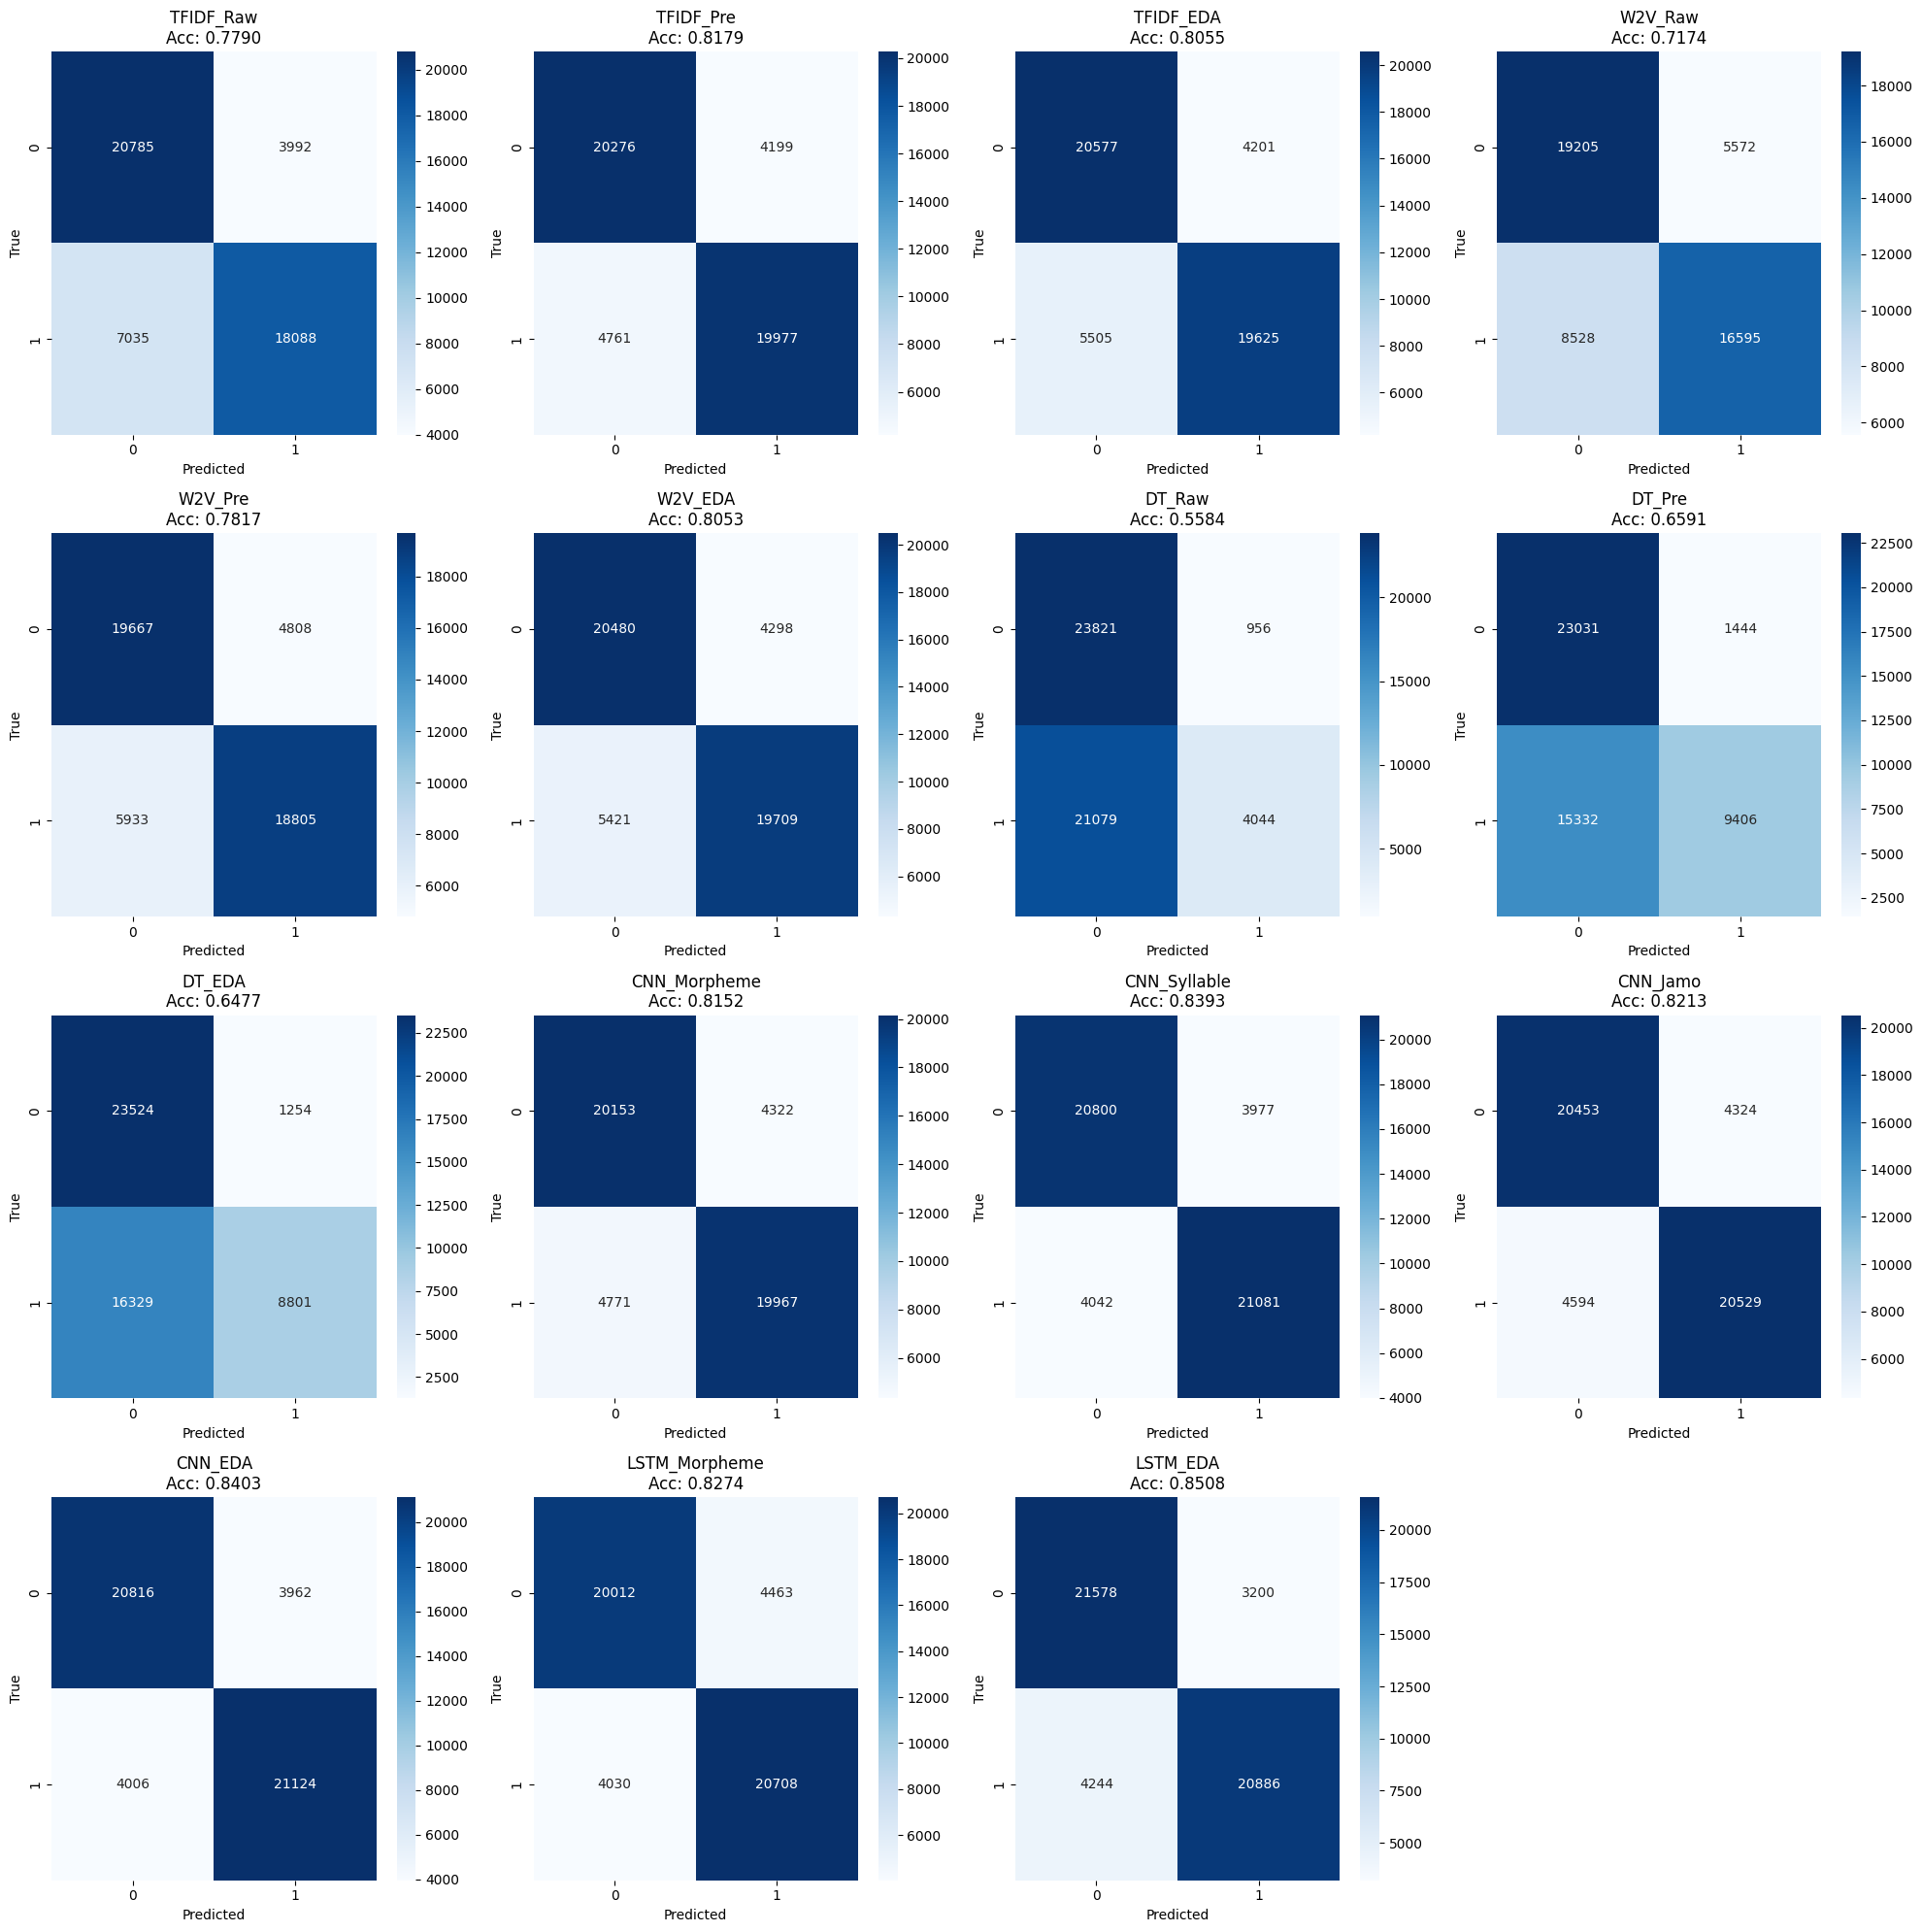

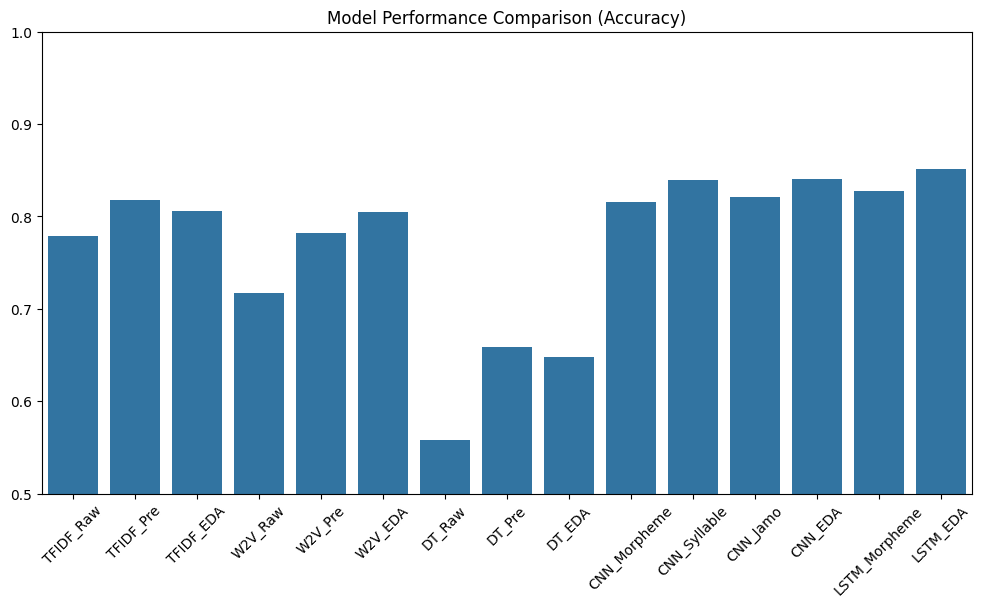


=== Final Accuracy Report ===
LSTM_EDA: 0.8508
CNN_EDA: 0.8403
CNN_Syllable: 0.8393
LSTM_Morpheme: 0.8274
CNN_Jamo: 0.8213
TFIDF_Pre: 0.8179
CNN_Morpheme: 0.8152
TFIDF_EDA: 0.8055
W2V_EDA: 0.8053
W2V_Pre: 0.7817
TFIDF_Raw: 0.7790
W2V_Raw: 0.7174
DT_Pre: 0.6591
DT_EDA: 0.6477
DT_Raw: 0.5584


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import os


model_names = [
    "TFIDF_Raw", "TFIDF_Pre", "TFIDF_EDA",
    "W2V_Raw", "W2V_Pre", "W2V_EDA",
    "DT_Raw", "DT_Pre", "DT_EDA",
    "CNN_Morpheme", "CNN_Syllable", "CNN_Jamo", "CNN_EDA",
    "LSTM_Morpheme", "LSTM_EDA"
]

results = {}

# 모델 이름에 따라 올바른 정답 라벨(y_true)을 가져오는 함수
def get_y_true(name):
    if "EDA" in name:
        return test_eda['labels']
    elif "Pre" in name or "Morpheme" in name:
        return test_morphs['labels']
    elif "Jamo" in name:
        return test_jamo['labels']
    else:
        return test_raw['labels']

plt.figure(figsize=(20, 20))

for i, name in enumerate(model_names):
    fname = f'prediction_{name}.txt'
    if not os.path.exists(fname):
        print(f"File not found: {fname}")
        continue

    # 예측 결과 로드
    with open(fname, 'r') as f:
        preds = [int(float(line.strip())) for line in f]

    # 해당 모델에 맞는 정답 라벨 가져오기
    y_true = get_y_true(name)

    # if 예측 파일과 정답 라벨의 길이가 다르면: 경고 출력 후 skip
    if len(preds) != len(y_true):
        print(f"[Warning] Length mismatch for {name}: Preds={len(preds)}, True={len(y_true)}")
        continue

    acc = accuracy_score(y_true, preds)
    results[name] = acc

    # 혼동 행렬(confusion matrix) 시각화
    cm = confusion_matrix(y_true, preds)
    plt.subplot(4, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name}\nAcc: {acc:.4f}")
    plt.xlabel('Predicted')
    plt.ylabel('True')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# 최종 성능 비교 그래프
plt.figure(figsize=(12, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.xticks(rotation=45)
plt.title("Model Performance Comparison (Accuracy)")
plt.ylim(0.5, 1.0)

plt.savefig('model_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 텍스트로 결과 출력
print("\n=== Final Accuracy Report ===")
for name, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {acc:.4f}")

### BERT 추가 실험

In [ ]:
import torch
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# [수정] AdamW는 torch.optim에서, 나머지는 transformers에서
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ==========================================
# 1. 설정 (경량화 모델 & 학습 강화)
# ==========================================
# MODEL_NAME = "klue/bert-base"        # (기존) 110M Params
MODEL_NAME = "klue/roberta-small"      # (변경) 68M Params -> 속도 빠름 & 성능 우수
BATCH_SIZE = 128                        # 가벼운 모델이라 배치 크기 확대 (32 -> 64)
EPOCHS = 5                             # 학습 횟수 증가 (2 -> 5)
LEARNING_RATE = 5e-5                   # 학습률

print(f"Selected Model: {MODEL_NAME}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# 2. 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# 3. 데이터셋 클래스 (RoBERTa는 token_type_ids 불필요)
class ReviewDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = str(self.data.iloc[idx]['document'])
        label = self.data.iloc[idx]['label']

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 4. 데이터 로더 생성 함수
def create_loaders(df, tokenizer, batch_size):
    # 라벨 비율 맞춰서 분리 (Stratify)
    train_split, valid_split = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

    train_ds = ReviewDataset(train_split, tokenizer)
    val_ds = ReviewDataset(valid_split, tokenizer)

    # num_workers=2로 데이터 로딩 병목 현상 완화
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader

# 5. 데이터 로드 (EDA 완료된 파일 활용)
if os.path.exists('ratings_train_eda.txt'):
    print("Loading Cleaned Data for BERT Pipeline...")
    df_eda_train = pd.read_csv('ratings_train_eda.txt', sep='\t').dropna()
    df_eda_test = pd.read_csv('ratings_test.txt', sep='\t').dropna() # 테스트용 (전처리만 적용)

    print(f"Train Size: {len(df_eda_train)} | Test Size: {len(df_eda_test)}")

    # DataLoader 생성
    train_loader_bert, val_loader_bert = create_loaders(df_eda_train, tokenizer, BATCH_SIZE)
else:
    print("Error: 'ratings_train_eda.txt' 파일이 없습니다. EDA 단계를 먼저 실행해주세요.")

Selected Model: klue/roberta-small
Device: cuda
Loading Cleaned Data for BERT Pipeline...
Train Size: 146123 | Test Size: 49997


In [4]:
# 1. 학습 함수 정의
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # 진행바 표시
    progress_bar = tqdm(data_loader, desc="Training")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        # 모델 순전파 (Forward)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        if hasattr(outputs, 'loss'):
            loss = outputs.loss
            logits = outputs.logits
        else: # 튜플로 반환된 경우 (loss, logits) 순서
            loss = outputs[0]
            logits = outputs[1]

        # 역전파 (Backward)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 정확도 계산 (Batch 단위)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # 진행바에 Loss 표시
        progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(data_loader), correct / total

# 2. 검증 함수 정의
def eval_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # 튜플/객체 호환 처리
            if hasattr(outputs, 'logits'):
                logits = outputs.logits
            else:
                logits = outputs[0]

            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

# 학습 실행
print(f"\n[Start Training] Model: {MODEL_NAME}, Epochs: {EPOCHS}, Batch: {BATCH_SIZE}")

# 명시적으로 딕셔너리 반환 요청
model_bert = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2, return_dict=True)
model_bert = model_bert.to(device)

# 옵티마이저 설정
optimizer_bert = AdamW(model_bert.parameters(), lr=LEARNING_RATE)

# 최고 성능 기록용 변수 초기화
best_val_acc = 0.0

# 학습 루프
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss, train_acc = train_epoch(model_bert, train_loader_bert, optimizer_bert, device)
    val_acc = eval_model(model_bert, val_loader_bert, device)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Validation 정확도가 갱신될 때마다 모델 가중치를 저장 (과적합 방지용)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_bert.state_dict(), "best_bert_model.pt")
        print(f"  -> Best Model Saved! (Acc: {best_val_acc:.4f})")

print("\nTraining Complete!")

model_bert.load_state_dict(torch.load("best_bert_model.pt"))
print(f"Loaded Best Model (Acc: {best_val_acc:.4f}) for Prediction")

# === [Test Prediction] ===
def predict_and_save(model, test_df, tokenizer, filename):
    # 테스트셋 전용 데이터셋/로더 생성
    test_ds = ReviewDataset(test_df, tokenizer)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    model.eval()
    all_preds = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting Test"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            if hasattr(outputs, 'logits'):
                logits = outputs.logits
            else:
                logits = outputs[0]

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())

    # 파일로 저장
    with open(filename, 'w') as f:
        for p in all_preds:
            f.write(f"{int(p)}\n")
    print(f"Saved predictions to: {filename}")
    return all_preds

# 예측 수행 및 저장
bert_preds = predict_and_save(model_bert, df_eda_test, tokenizer, "prediction_BERT_EDA.txt")


[Start Training] Model: klue/roberta-small, Epochs: 5, Batch: 128
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Epoch 1/5
Training: 100%|██████████| 914/914 [17:36<00:00,  1.16s/it, loss=0.225]
Train Loss: 0.2986 | Train Acc: 0.8716 | Val Acc: 0.8935

Epoch 2/5
Training: 100%|██████████| 914/914 [17:35<00:00,  1.16s/it, loss=0.142]
Train Loss: 0.2136 | Train Acc: 0.9145 | Val Acc: 0.8937

Epoch 3/5
Training: 100%|██████████| 914/914 [17:35<00:00,  1.15s/it, loss=0.194]
Train Loss: 0.1562 | Train Acc: 0.9402 | Val Acc: 0.8977

Epoch 4/5
Training: 100%|██████████| 914/914 [17:35<00:00,  1.15s/it, loss=0.0466]
Train Loss: 0.1108 | Train Acc: 0.9595 | Val Acc: 0.8995

Epoc